# Analysis code for Sassenhagen, Blything, Lieven & Ambridge (2018)

This documents the actual analysis for our Collabra paper. You can read and download it at: [www.collabra.org/articles/10.1525/collabra.87](https://www.collabra.org/articles/10.1525/collabra.87).

**Frequency Sensitivity of Neural Responses to English Verb Argument Structure Violations**

## Abstract

How are verb-argument structure preferences acquired? Children typically receive very little negative evidence, raising the question of how they come to understand the restrictions on grammatical constructions. Statistical learning theories propose stochastic patterns in the input contain sufficient clues. For example, if a verb is very common, but never observed in transitive constructions, this would indicate that transitive usage of that verb is illegal. Ambridge et al.(2008) have shown that in offline grammaticality judgements of intransitive verbs used in transitive constructions, low-frequency verbs elicit higher acceptability ratings than high-frequency verbs, as predicted if relative frequency is a cue during statistical learning. Here, we investigate if the same pattern also emerges in on-line processing of English sentences. EEG was recorded while healthy adults listened to sentences featuring transitive uses of semantically matched verb pairs of differing frequencies. We replicate the finding of higher acceptabilities of transitive uses of low-vs. high-frequency intransitive verbs. Event-Related Potentials indicate a similar result: early electrophysiological signals distinguish between misuse of high-vs low-frequency verbs. This indicates online processing shows a similar sensitivity to frequency as off-line judgements, consistent with a parser that reflects an original acquisition of grammatical constructions via statistical cues. However, the nature of the observed neural responses was not of the expected, or an easily interpretable, form, motivating further work into neural correlates of online processing of syntactic constructions.

## Preliminaries

We begin with imports ...

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordfreq import zipf_frequency, word_frequency

import mne
mne.set_log_level(False)

exp = "ryan"
sfreq = 200
sourceloc = "../"
event_id = {
    'Transitive/High':201,
    'Intransitive/High': 200,
    'Transitive/Low': 101,
    'Intransitive/Low':100}
baseline = (None, 0)

## Load in data

Data is already fully preprocessed for the sake of speed.

In [2]:
all_epochs = [mne.read_epochs(fname) for fname in glob(sourceloc + "epo/*.fif*")]

In [3]:
# apologies for the double-nested comprehension. There is nothing fancy going on here.

all_evokeds = {cond: [epochs[cond].average().apply_baseline((None, 0)).savgol_filter(6)
                      for epochs in all_epochs] for cond in event_id}
all_evokeds

/home/jona/tools/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


{'Transitive/High': [<Evoked  |  'Transitive/High' (mean, N=40), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=30), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=40), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=38), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=38), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=35), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=36), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=40), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=39), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=40), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=40), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transitive/High' (mean, N=40), [-0.3, 0.9] sec, 61 ch, ~275 kB>,
  <Evoked  |  'Transi

## Set up statistics

We calculate a cluster-based permutation test on the main contrasts. This may take a while.

In [4]:
from mne.stats import spatio_temporal_cluster_test, spatio_temporal_cluster_1samp_test
tfce = dict(start=.1, step=.2)  # we could go more fine grained here, but it will not matter much
connectivity, names = mne.channels.find_ch_connectivity(all_epochs[0].info, "eeg")

In [5]:
# oh my, more nested comps ...

pairs = [['Intransitive/High', 'Transitive/High'],
        ['Intransitive/Low', 'Transitive/Low']]
itr, tr = [np.array([mne.combine_evoked((epochs[cond1].average(),
                                        -epochs[cond2].average()), weights="equal"
                                       ).set_eeg_reference().apply_baseline(baseline).data.T
                     for epochs in all_epochs])
           for cond1, cond2 in pairs]
interact = np.subtract(itr, tr)

gram = np.array([mne.combine_evoked((
    epochs['Intransitive/High'].average(),
    epochs['Intransitive/Low'].average(),
   -epochs['Transitive/High'].average(),
   -epochs['Transitive/High'].average()), weights="equal"
                         ).set_eeg_reference().apply_baseline(baseline).data.T
                                      for epochs in all_epochs])

freq = np.array([mne.combine_evoked((
    -epochs['Intransitive/High'].average(),
     epochs['Intransitive/Low'].average(),
    -epochs['Transitive/High'].average(),
     epochs['Transitive/High'].average()), weights="equal"
                         ).set_eeg_reference().apply_baseline(baseline).data.T
                                      for epochs in all_epochs])

data_for_1samp = {"Frequency": freq, "Grammaticality": gram, "Interaction": interact}

In [6]:
# here we are running the actual permutation test.

stat_res = dict()
for k, v in data_for_1samp.items():
    print(k)
    stat_res[k] = spatio_temporal_cluster_1samp_test(
        v,
        threshold=tfce, n_jobs=-1, n_permutations=1000, out_type="mask",
        connectivity=connectivity, buffer_size=None)

Frequency
Grammaticality
Interaction


## Plot results

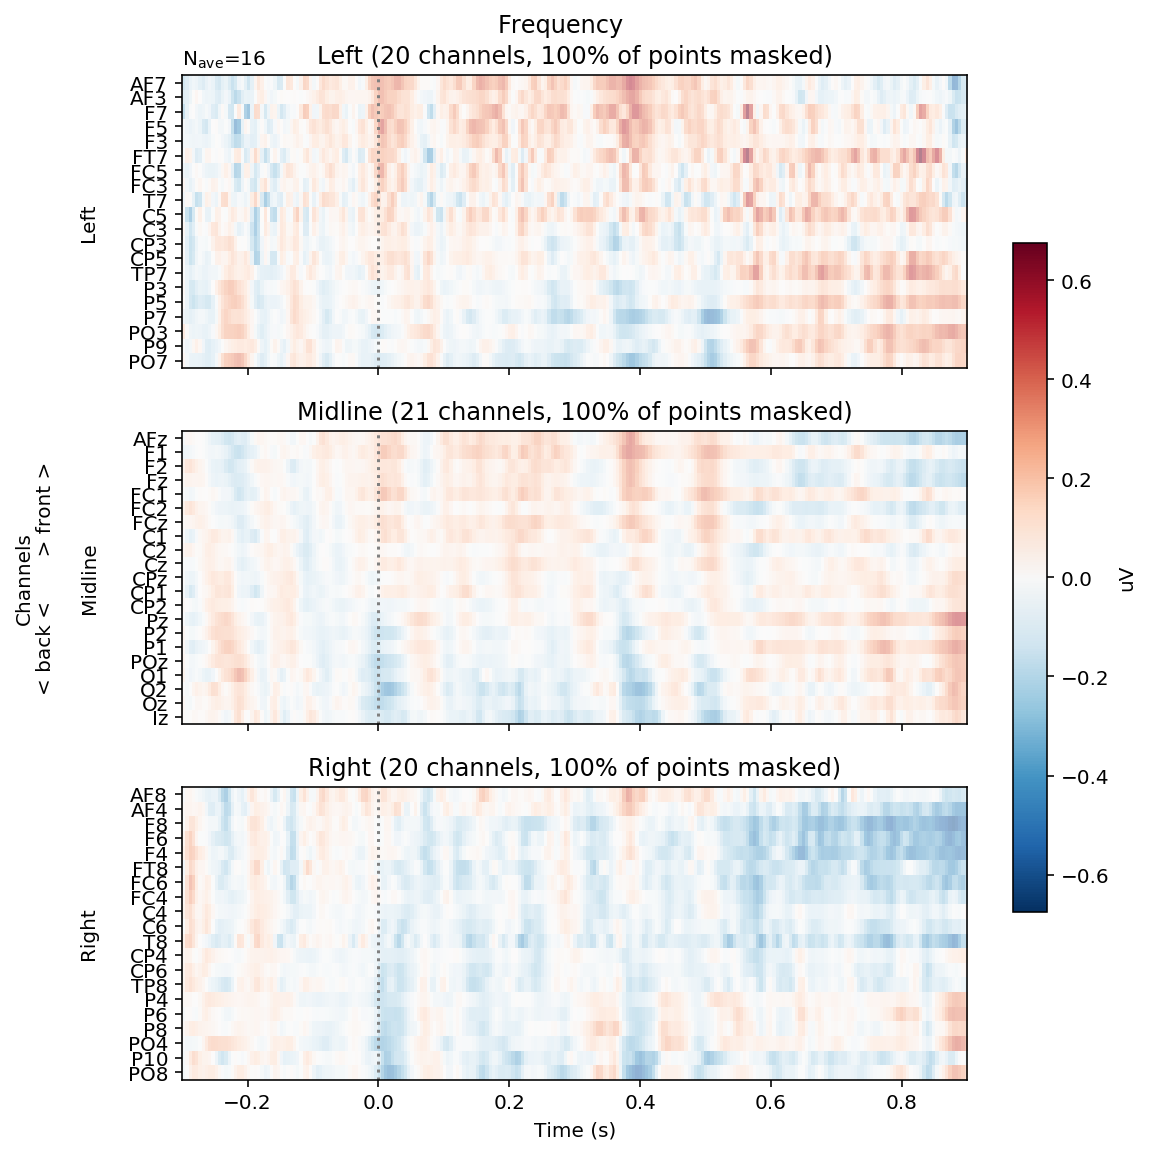

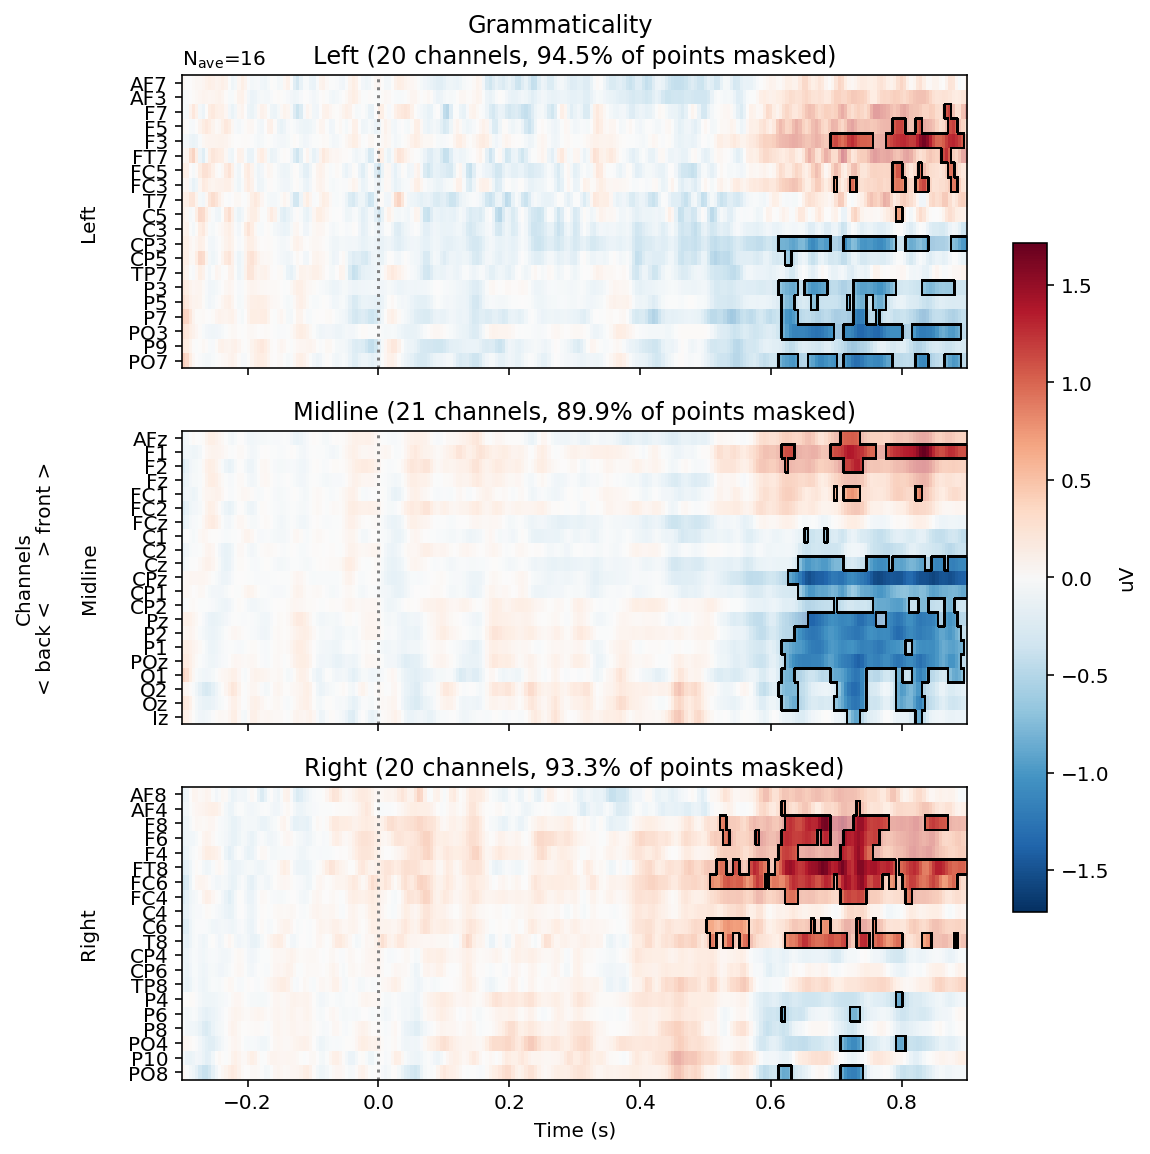

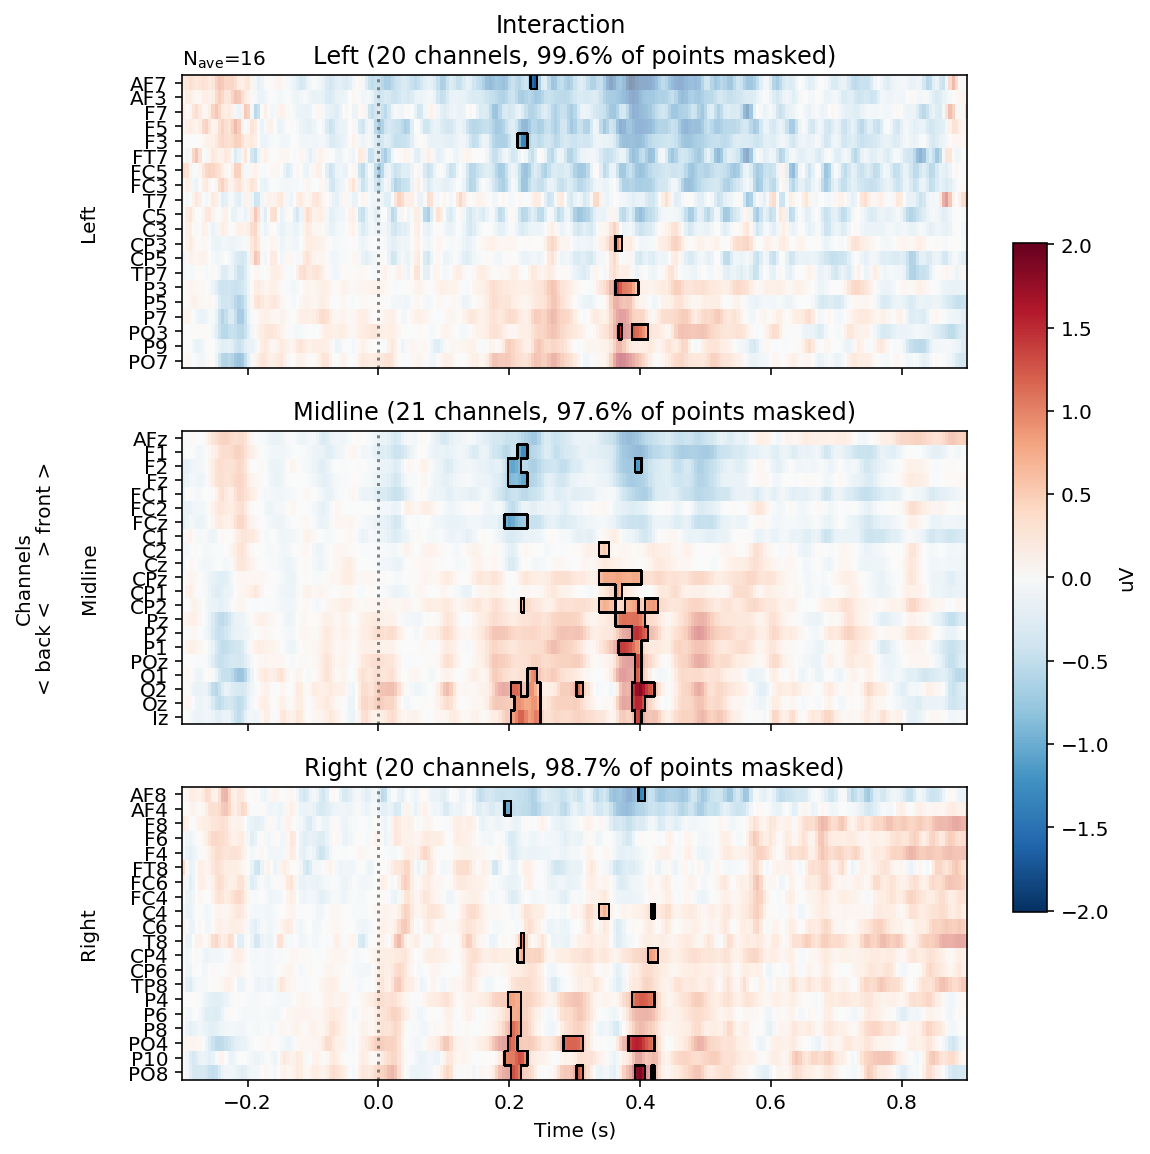

In [8]:
# Create ROIs by checking channel labels
epochs = all_epochs[0].copy()
pos = mne.channels.find_layout(epochs.info).pos
rois = dict()
for pick, channel in enumerate(epochs.ch_names):
    last_char = channel[-1]  # for 10/20, last letter codes the hemisphere
    roi = ("Midline" if last_char in "z12" else
           ("Left" if int(last_char) % 2 else "Right"))
    rois[roi] = rois.get(roi, list()) + [pick]

# sort channels from front to center
# (y-coordinate of the position info in the layout)
rois = {roi: np.array(picks)[pos[picks, 1].argsort()]
        for roi, picks in rois.items()}

# Visualize the results

for cond, data in data_for_1samp.items():
    fig, axes = plt.subplots(nrows=3, figsize=(8, 8))

    evoked = all_epochs[0].average()
    evoked.data = data.mean(0).T
    evoked.nave = len(data)
    t_obs, clusters, cluster_pv_erp, H0 = stat_res[cond]
    mask = cluster_pv_erp.reshape(t_obs.shape).T < .05
    vmax = np.abs(evoked.data).max() * 1e6

    # Iterate over ROIs and axes
    axes = axes.ravel().tolist()
    for roi_name, ax in zip(sorted(rois.keys()), axes):
        picks = rois[roi_name]
        evoked.plot_image(axes=ax, picks=picks, exclude=[],
                          titles=roi_name, show=False, colorbar=False,
                          clim={"eeg": (-vmax, vmax)}, time_unit='s',
                          mask=mask, mask_cmap="RdBu_r", mask_alpha=.5)
        evoked.nave = None
        ax.set_yticks((np.arange(len(picks))) + .5)
        ax.axvline(linestyle=":", color="grey")
        ax.set_yticklabels([evoked.ch_names[idx] for idx in picks])
        if not ax.is_last_row():  # remove xticklabels for all but bottom axis
            ax.set_xlabel('')
            ax.set_xticklabels([])
        s = "{}\n\n{}\n".format(("Channels\n< back <       > front >"
                         if roi_name == "Midline" else ""), roi_name)
        ax.set_ylabel(s)

    fig.colorbar(ax.images[-1], ax=axes, fraction=.1, aspect=20,
                 pad=.05, shrink=2/3, label="uV", orientation="vertical");
    fig.suptitle(cond, y=1)
#    fig.savefig("../figs/ryan_masked_{}.pdf".format(cond), bbox_inches='tight')


## ERP plots

In [9]:
# Create ROIs by checking channel labels
pos = mne.channels.find_layout(epochs.info).pos
double_rois = dict()
for pick, channel in enumerate(epochs.ch_names):
    last_char = channel[-1]  # for 10/20, last letter codes the hemisphere
    lat = ("Midline" if last_char in "z12" else
           ("Left" if int(last_char) % 2 else "Right"))
    ant = ("Posterior" if 
           any(channel.startswith(letter) for letter in ("CP", "P", "O", 'I'))
           else "Anterior")
    double_rois[lat, ant] = double_rois.get((lat, ant), list()) + [pick]


Text(0.5, 0.98, 'Event-Related Potentials, with 68% CI')

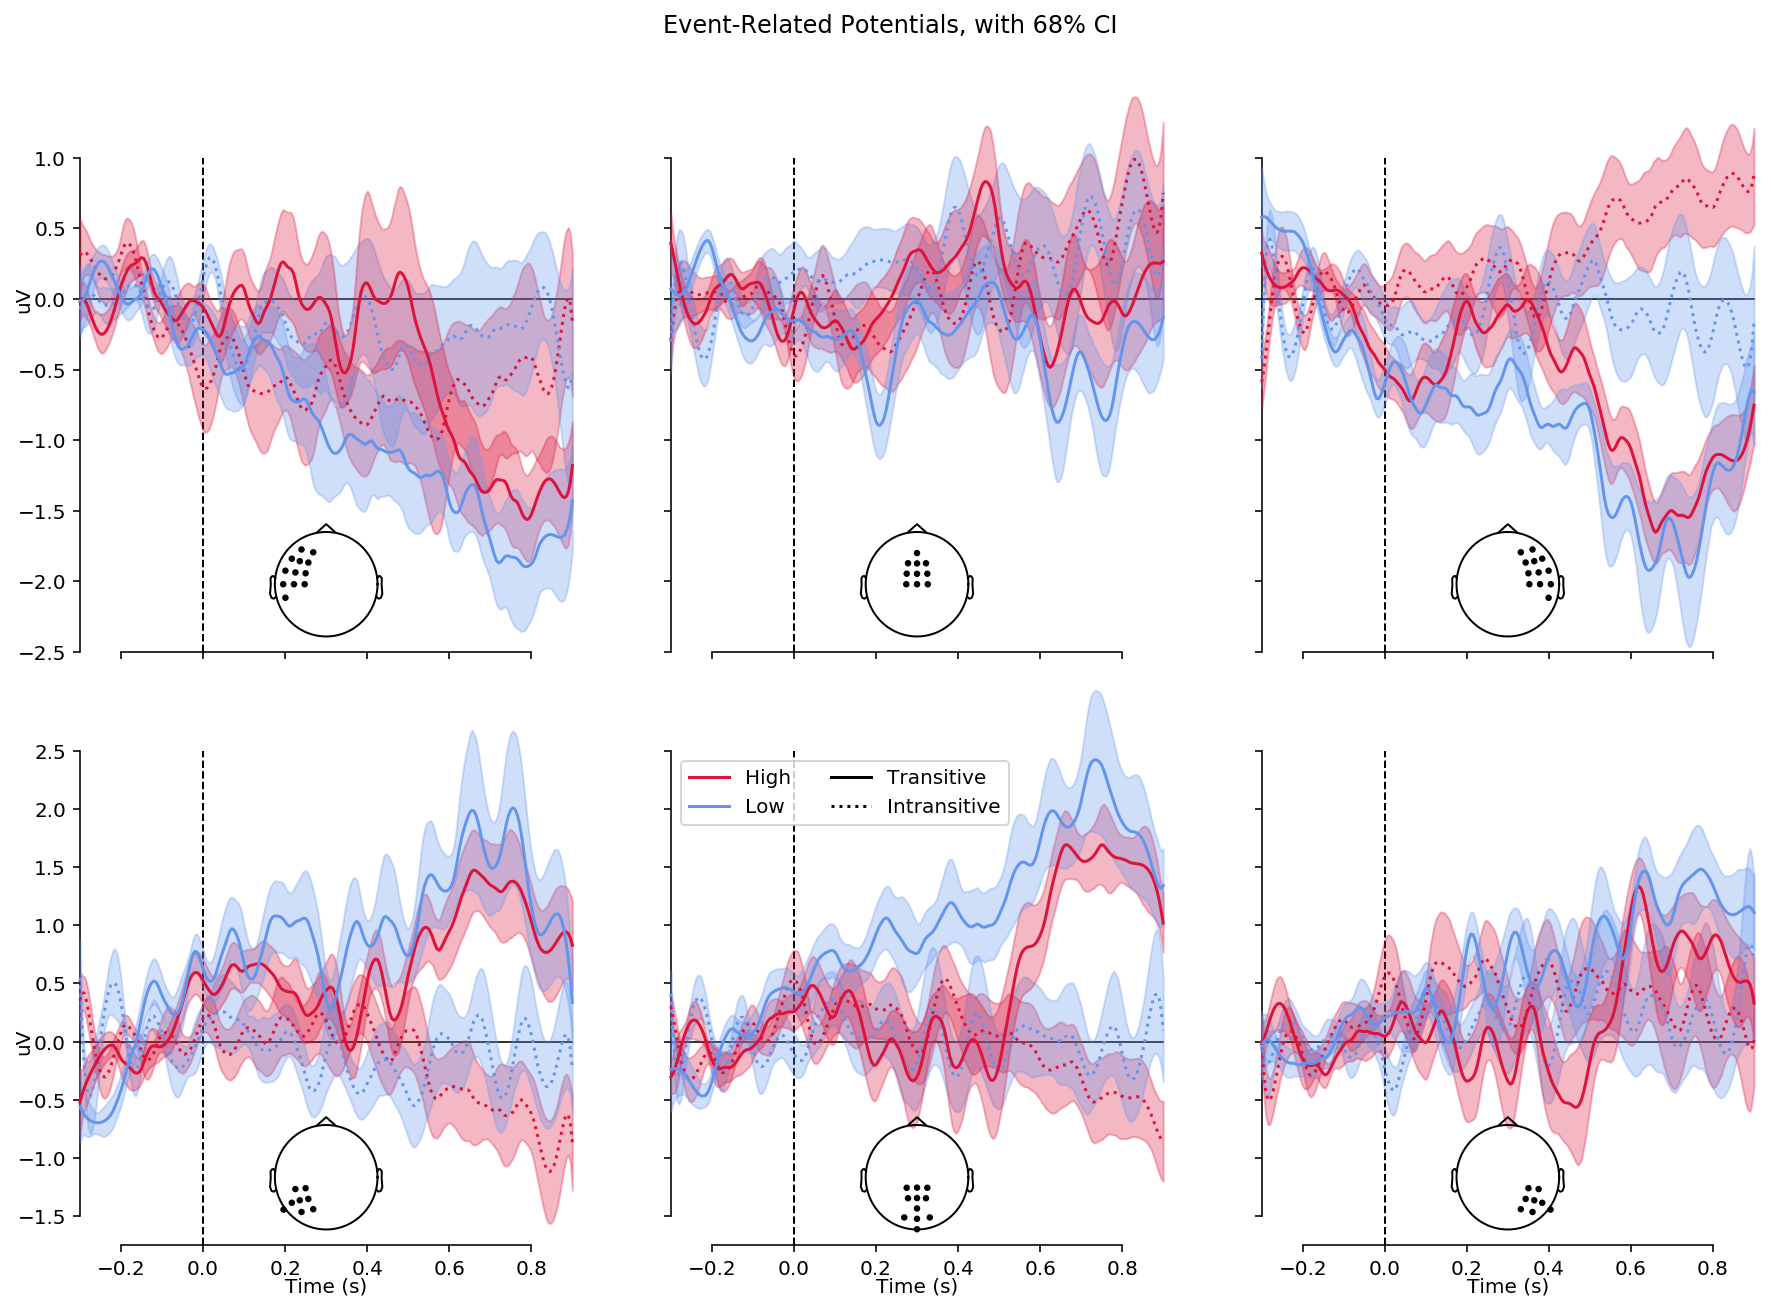

In [10]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
where_dict = {'Left': 0, 'Midline': 1, 'Right': 2, 'Anterior': 0, 'Posterior': 1}

for (lat, ant), picks in double_rois.items():
    ax = axes[where_dict[ant], where_dict[lat]]
    mne.viz.plot_compare_evokeds(
        all_evokeds,
        picks=picks,
        colors={"High": "Crimson", "Low": "Cornflowerblue"},
        linestyles={"Transitive": "-", "Intransitive": ":"},
        split_legend=True, title="", ci=.68, axes=ax,
        ylim=dict(eeg=[-2.5 if ant == 'Anterior' else -1.75,
                       1 if ant == 'Anterior' else 2.5]),
        truncate_yaxis="max_ticks", show_sensors='lower center', show=False,
        show_legend=2 if (lat, ant) == ('Midline', 'Posterior') else False)
    if not ax.is_last_row():
        ax.set_xlabel('')
        ax.set_xticklabels([])
    if not ax.is_first_col():
        ax.set_ylabel('')
        ax.set_yticklabels([])
fig.suptitle("Event-Related Potentials, with 68% CI")

#fig.savefig("../figs/ryan_evoked.pdf", bbox_inches='tight')

## Read in violation contrast scalp map to extract the interaction effect

We are taking the topography of the violation effect to visualise the interaction effect (i.e., we take it as a spatial filter, and do a simple dot product). This is in principle double dipping. It is *only* meant for visualisation.

In [11]:
low = mne.combine_evoked([mne.grand_average(all_evokeds["Intransitive/Low"]),
                          mne.grand_average(all_evokeds["Transitive/Low"])], weights=(-1, 1))
high = mne.combine_evoked([mne.grand_average(all_evokeds["Intransitive/High"]),
                           mne.grand_average(all_evokeds["Transitive/High"])], weights=(-1, 1))
inter = mne.combine_evoked([low, high], weights=(-1, 1))
viol = mne.combine_evoked([low, high], weights=(1, 1))
viol_scalp = viol.copy().crop(.6, .8).data.mean(1)

In [13]:
all_res_time = []

ntile = 5

for epochs in all_epochs:
    n_splits = len(epochs) // ntile
    ranges = []
    for ii in range(ntile):
        e_ = epochs[ii * n_splits:(ii + 1) * n_splits]
        low = mne.combine_evoked([e_["Intransitive/Low"].average(),
                                  e_["Transitive/Low"].average()], weights=(-1, 1))
        high = mne.combine_evoked([e_["Intransitive/High"].average(),
                                   e_["Transitive/High"].average()], weights=(-1, 1))
        inter = mne.combine_evoked([low, high], weights=(-1, 1)).crop(.2, .4).data.mean(1) @ -viol_scalp
        ranges.append(inter)# * 10e9)
    all_res_time.append(ranges)

Here we are binning the experiment in time to see if the effect changes over time.

In [14]:
df_ranges = pd.DataFrame(all_res_time).assign(Subject=range(len(all_res_time))).melt(
    var_name='Time (experiment quintile)', value_name='Interaction Effect', id_vars=['Subject'])

/home/jona/tools/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0.98, 'Time trend of Grammaticality by Frequency interaction effect')

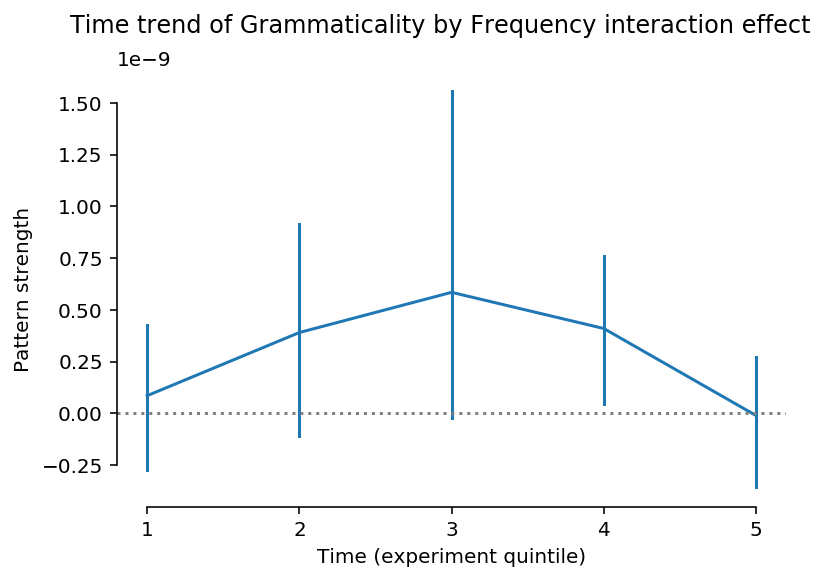

In [15]:
g = sns.lineplot(x='Time (experiment quintile)', y='Interaction Effect', data=df_ranges, err_style="bars")
sns.despine(trim=True)
g.axes.axhline(0, color="grey", linestyle=":")
g.axes.set_ylabel("Pattern strength")
g.axes.set_xticks(range(5))
g.axes.set_xticklabels([1, 2, 3, 4, 5])
g.figure.suptitle("Time trend of Grammaticality by Frequency interaction effect")

#g.figure.savefig("../figs/ryan_timetrend.pdf", bbox_inches='tight')

In [16]:
from scipy.stats import wilcoxon

wilcoxon(df_ranges.astype(float).groupby("Subject").corr().T.loc["Time (experiment quintile)"].values[::2])

WilcoxonResult(statistic=52.0, pvalue=0.40804420568711997)

And for the violation effect itself ...

In [17]:
res_dot = {key: [ev.crop(.2, .4).data.mean(1) @ viol_scalp for ev in vals]
           for key, vals in all_evokeds.items()}

In [18]:
df_res_dot = pd.DataFrame(res_dot).melt()
df_res_dot["Violation"] = df_res_dot.variable.str.contains("Intr")
df_res_dot["HF"] = df_res_dot.variable.str.contains("High")

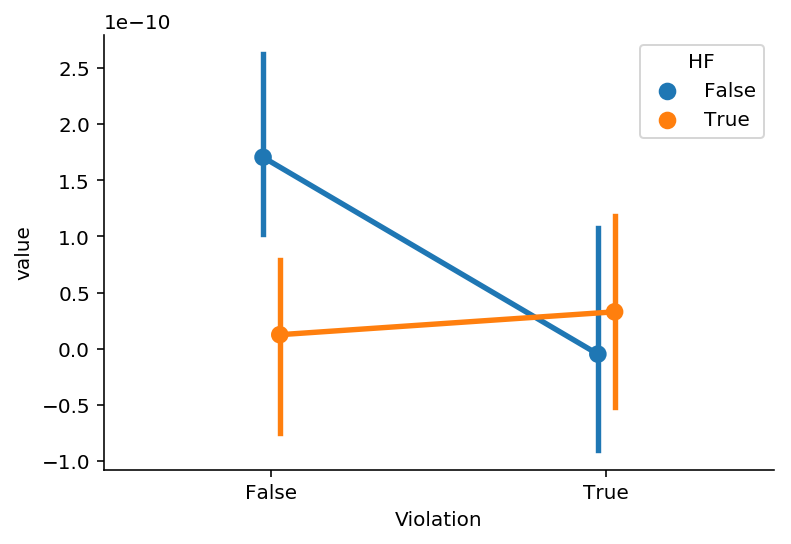

In [19]:
sns.pointplot(data=df_res_dot, x="Violation", hue="HF", y="value", kind="factor", dodge=True);
sns.despine()